## Imports

In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import col, to_date, to_char, lit



from neuralforecast.losses.pytorch import GMM, MQLoss, DistributionLoss, MAE, PMM, HuberLoss, TukeyLoss, HuberQLoss, HuberMQLoss, MultiOutputMAE
from neuralforecast.core import NeuralForecast
from utilsforecast.plotting import plot_series
from neuralforecast.models import BiTCN, DeepAR,TSMixerx, TiDE, MLP, TFT, RNN, TCN, MLPMultivariate, NBEATSx, DeepNPTS, NHITS, BiTCN,LSTM, DilatedRNN, KAN, GRU, PatchTST
from neuralforecast.tsdataset  import TimeSeriesDataset

import pandas as pd
import numpy as np
import logging
import json
from nbdev.showdoc import show_doc

import plotly.express as px
import plotly.io as pio
import os  

pio.renderers.default = "browser"

## Conexión

In [2]:
with open("config.json", "r") as file:
    connection_parameters = json.load(file)

In [3]:
sess = Session.builder.configs( connection_parameters ).create()

c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\.venv\Lib\site-packages\snowflake\connector\config_manager.py:351: UserWarning:

Bad owner or permissions on C:\Users\julian.quintero\.snowflake\connections.toml



Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://identity-services.elcorteingles.es:443/samlsso?SAMLRequest=pZJbc9owEIX%2Fikd9ti1fCkQDZAg0E5obA6ad6ZtiL6BBlhytjOHfV8Ywkz4kL32zpbP6zu7Z4e2xlN4BDAqtRiQKKPFA5boQajsi6%2BzeHxAPLVcFl1rBiJwAye14iLyUFZvUdqeW8F4DWs89pJC1FyNSG8U0R4FM8RKQ2ZytJs9PLA4o44hgrMORS0mBwrF21lYsDJumCZok0GYbxpTSkN6ETtVKvpEPiOprRmW01bmW15Kj6%2BkTRBTStEU4hSMsLoV3QnUj%2BIry1omQPWTZwl%2B8rjLiTa7dTbXCugSzAnMQOayXT50BdA7ejv00jZKgcXPzoTa6gqAy4sAtSKH2ASrdbCTfQ67LqraOEbivcANFKPVWuMnNZyNS7UXR%2B%2FnSS3jRl8fp4O7H4%2Bt7r3c6RaafZPo3HB9omi%2Fnu%2FWKP0KTE%2B%2FXNee4zXmOWMNctelad0Tj7z6NfTrIopjFPUaT4CaN%2FxBv5lwKxe258tqCKEBZYU8%2Bdv1hADLXxoIzK9s%2FZGmahG1WiJp0G8POSDP%2BvzkMw49vXVbxxaUzny20FPnJu9em5Pbz8KIgOp%2BIwt%2BcpQxKLuSkKAwguhCl1M3UgPMxItbUQMJxR%2F1358d%2FAQ%3D%3D&RelayState=ver%3A1-

## Data Preparation

In [9]:
features = '''
CAA_UAT.STG_FCDP.TEMP_TB_FEATURES_JAQB_TotD
CAA_UAT.STG_FCDP.TEMP_TB_FEATURES_JAQB_TotM
CAA_UAT.STG_FCDP.TEMP_TB_FEATURES_JAQB_PrepCsFTDaNoPrime
CAA_UAT.STG_FCDP.TEMP_TB_FEATURES_JAQB_LibeCsT
CAA_UAT.STG_FCDP.TEMP_TB_FEATURES_JAQB_PrepCcDC
CAA_UAT.STG_FCDP.TEMP_TB_FEATURES_JAQB_RecoCcFC

ML_FORECAST_POC.DATA.TONI_EMB_PROMOS
ML_FORECAST_POC.DATA.TONI_EMB_PROMOS_DIM10
'''

In [4]:
problem = 'LibeCsT' # Prime, LibeCsT, PrepCsFTDaNoPrime, TotD, PrepCcDC

In [5]:
if problem == 'Prime':
    df = pd.read_csv('01_FEATURES_PRIME.csv')
    df['DT_FECHA'] = pd.to_datetime(df['DT_FECHA'])
    df = df.drop(['CO_TIPO_FECHA', 'CO_TIPO_METODO_ENVIO','IS_PRIMERITI','DS_DIVISION_AUM'], axis=1)

    df = df.rename(columns={'DT_FECHA': 'ds',    'CO_DIVISION_AUM': 'unique_id',    'QT_UNIDADES': 'y'})

    exogenous_vars = [
        'PC_DESCUENTO_A_PUBLICAR', 'PC_DESCUENTO_APLICADO', 'VL_POTENCIAL_ESTIMADO', 
        'VL_FORECAST', 'QT_REFS_ESTIMADAS', 'QT_REFS_NUEVAS_ESTIMADAS', 
        'QT_UDS_STOCK_ESTIMADO', 'RATIO_FORE_POTE', 'INTENSIDAD', 'STOCK_DESCUENTO',
        'REFS_DESCUENTO', 'RATIO_STOCK_REFS', 'QT_FORE_DIARIO', 'VL_FORE_DIARIO',
        'STOCK_RELATIVO', 'NRO_ACCIONES', 'QT_FORECAST_desc'
    ]

    df['month'] = df['ds'].dt.month
    df["day_of_week"] = df["ds"].dt.dayofweek + 1  # 1: Lunes, 7: Domingo
    df["day_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["day_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

    # exogenous_vars += ['month', 'year','day', 'day_of_week' , 'day_of_year']
    exogenous_vars += ['month','day_of_week', 'day_sin', 'day_cos']
    
    df_model = df[['unique_id', 'ds', 'y'] + exogenous_vars].sort_values(by=['unique_id', 'ds']).copy()

    df_model = df_model[['unique_id', 'ds', 'y'] + exogenous_vars]
    df_model = df_model.sort_values(by=['unique_id','ds'])
    df_model = df_model[df_model['unique_id'] != 'PRIME_NOCAT']

    dummies = pd.get_dummies(df['unique_id'], prefix='CAT')
    df_with_dummies = pd.concat([df_model[['unique_id']], dummies], axis=1)
    static_df  = df_with_dummies.groupby('unique_id').max().reset_index()
    stat_exog_list = static_df.columns[1:].to_list()
else:
    df_problem = sess.sql( f'''SELECT *  FROM CAA_UAT.STG_FCDP.TEMP_TB_FEATURES_JAQB_{problem}''' ).to_pandas()
    
    with open('variables.json', 'r') as f:
        variables = json.load(f)

    if problem == 'LibeCsT':
        i_cs = variables['i_cs_LibeCsT']
    elif problem == 'PrepCsFTDaNoPrime':
        i_cs = variables['i_cs_PrepCsFTDaNoPrime']
    else:
        i_cs = variables['i_cs']


    df = df_problem.copy()
    vars_keys = ['KEY_DS','CO_TIPO_METODO_ENVIO','KEY','LABEL_N0','LABEL_N1','LABEL_N2','LABEL_N3','LABEL_N4','LABEL_N5','LABEL_N6','LABEL_N7']
    df.rename(columns={'DT_FECHA': 'FECHA'}, inplace=True)

    df['FECHA'] = pd.to_datetime(df['FECHA'])

    df = df[['FECHA', 'LABEL', 'QT_UNIDADES'] + vars_keys + i_cs]

    #df = df[['FECHA', 'LABEL', 'QT_UNIDADES']+ i_cs]
    df['OI_BLACK_FRIDAY_CTE'] = df[['OI_BLACK_FRIDAY_FASE_1_CTE', 'OI_BLACK_FRIDAY_FASE_2_CTE']].sum(axis=1)
    #df['IN_CIERRE'] = df.filter(like='IN_CIERRE_M').sum(axis=1)

    # Eliminar columnas utilizadas en la suma
    cols_to_drop = ['OI_BLACK_FRIDAY_FASE_1_CTE', 'OI_BLACK_FRIDAY_FASE_2_CTE']
    cols_to_drop += df.filter(like='DT_WD').columns.tolist()
    cols_to_drop += df.filter(like='DT_M').columns.tolist()
    #cols_to_drop += df.filter(like='IN_CIERRE_M').columns.tolist()
    #cols_to_drop += df.filter(like='_IX').columns.tolist()
    #cols_to_drop += df.filter(like='_IX2').columns.tolist()
    #cols_to_drop += df.filter(like='_INI').columns.tolist()
    #cols_to_drop += df.filter(like='_FIN').columns.tolist()
    df.drop(columns=cols_to_drop, inplace=True)


    
    df["day_of_week"] = df["FECHA"].dt.dayofweek + 1  # 1: Lunes, 7: Domingo
    df["day_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["day_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

    df['month'] = df['FECHA'].dt.month
    df["month_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 12)

    exogenous_vars = [col for col in df.columns if col not in ['FECHA', 'LABEL', 'QT_UNIDADES'] + vars_keys]

    df_model = df[['LABEL', 'FECHA', 'QT_UNIDADES'] + exogenous_vars].sort_values(by=['LABEL', 'FECHA']).copy()

    df_model.rename(columns={'FECHA': 'ds', 'LABEL': 'unique_id', 'QT_UNIDADES': 'y'}, inplace=True)

    dummies = pd.get_dummies(df_model['unique_id'], prefix='CAT')
    df_with_dummies = pd.concat([df_model[['unique_id']], dummies], axis=1)
    static_df  = df_with_dummies.groupby('unique_id').max().reset_index()
    stat_exog_list = static_df.columns[1:].to_list()

print(df_model.sort_values(by=['unique_id','ds']).head().to_string())
print(df_model.sort_values(by=['unique_id','ds']).tail().to_string())

     unique_id         ds       y  IN_CIERRE_90_M1  IN_CIERRE_90_M2  IN_CIERRE_90_M3  IN_CIERRE_90_M4  IN_CIERRE_90_M5  IN_CIERRE_90_M6  IN_CIERRE_90_M7  IN_CIERRE_90_M8  IN_CIERRE_90_M9  IN_CIERRE_90_M10  IN_CIERRE_90_M11  IN_CIERRE_90_M12  IN_CIERRE_50_M1  IN_CIERRE_50_M2  IN_CIERRE_50_M3  IN_CIERRE_50_M4  IN_CIERRE_50_M5  IN_CIERRE_50_M6  IN_CIERRE_50_M7  IN_CIERRE_50_M8  IN_CIERRE_50_M9  IN_CIERRE_50_M10  IN_CIERRE_50_M11  IN_CIERRE_50_M12  IN_FESTIVO  DIC_17  DIC_18  DIC_19  DIC_20  DIC_21  DIC_22  DIC_23  DIC_24  DIC_26  DIC_27  DIC_28  DIC_29  DIC_30  ENE_1  ENE_2  ENE_3  ENE_4  ENE_5  ENE_6  OI_8_DIAS_DE_ORO_CTE  OI_8_DIAS_DE_ORO_IX  OI_8_DIAS_DE_ORO_IX2  OI_8_DIAS_DE_ORO_INI  OI_8_DIAS_DE_ORO_FIN  OI_BLACK_FRIDAY_FASE_1_IX  OI_BLACK_FRIDAY_FASE_1_IX2  OI_BLACK_FRIDAY_FASE_1_INI  OI_BLACK_FRIDAY_FASE_1_FIN  OI_BLACK_FRIDAY_FASE_2_IX  OI_BLACK_FRIDAY_FASE_2_IX2  OI_BLACK_FRIDAY_FASE_2_INI  OI_BLACK_FRIDAY_FASE_2_FIN  OI_CYBER_MONDAY_CTE  OI_CYBER_MONDAY_IX  OI_CYBER_MONDAY_IX2  

In [121]:
# print(df[(df['ds'] >= '2024-11-20') & (df['ds'] <= '2024-12-03') & (df['unique_id'] == 'ENVIOS')][['ds', 'unique_id', 'OI_BLACK_FRIDAY_CTE']].sort_values(by='ds').to_string())

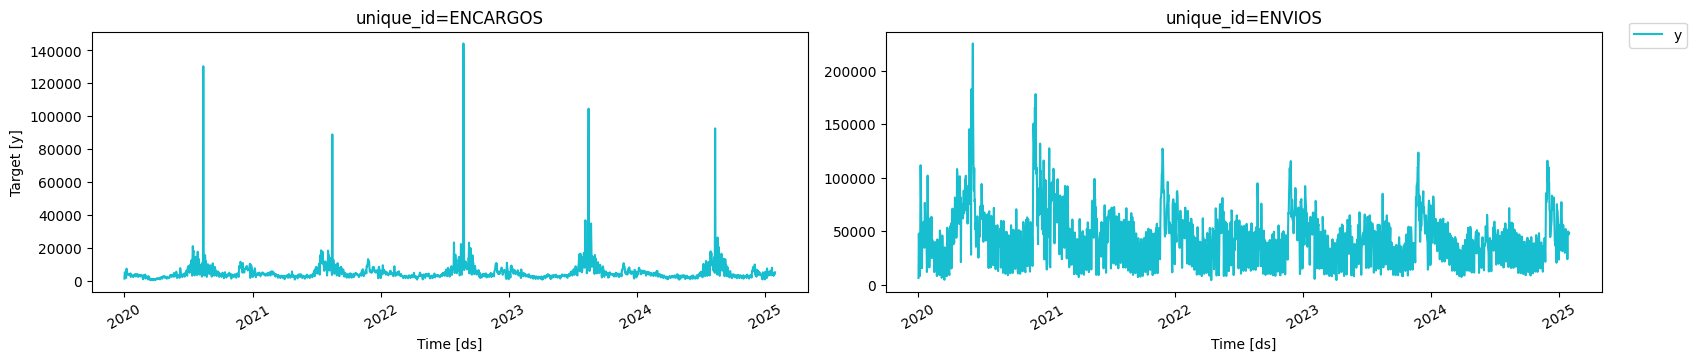

In [6]:
plot_series(df_model)

## Def Model

In [6]:
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

In [8]:
class CustomConv1d(nn.Module):
    """
    Forward- and backward looking Conv1D
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, dilation=1, mode='backward', groups=1):
        super().__init__()
        k = np.sqrt(1 / (in_channels * kernel_size))
        weight_data = -k + 2 * k * torch.rand((out_channels, in_channels // groups, kernel_size))
        bias_data = -k + 2 * k * torch.rand((out_channels))
        self.weight = nn.Parameter(weight_data, requires_grad=True)
        self.bias = nn.Parameter(bias_data, requires_grad=True)  
        self.dilation = dilation
        self.groups = groups
        if mode == 'backward':
            self.padding_left = padding
            self.padding_right= 0
        elif mode == 'forward':
            self.padding_left = 0
            self.padding_right= padding            

    def forward(self, x):
        xp = F.pad(x, (self.padding_left, self.padding_right))
        return F.conv1d(xp, self.weight, self.bias, dilation=self.dilation, groups=self.groups)

class TCNCell(nn.Module):
    """
    Temporal Convolutional Network Cell, consisting of CustomConv1D modules.
    """    
    def __init__(self, in_channels, out_channels, kernel_size, padding, dilation, mode, groups, dropout):
        super().__init__()
        self.conv1 = CustomConv1d(in_channels, out_channels, kernel_size, padding, dilation, mode, groups)
        self.conv2 = CustomConv1d(out_channels, in_channels * 2, 1)
        self.drop = nn.Dropout(dropout)
        
    def forward(self, x):
        h_prev, out_prev = x
        h = self.drop(F.gelu(self.conv1(h_prev)))
        h_next, out_next = self.conv2(h).chunk(2, 1)
        return (h_prev + h_next, out_prev + out_next)

In [9]:
class BiTCN(BaseWindows):
    """ BiTCN

    Bidirectional Temporal Convolutional Network (BiTCN) is a forecasting architecture based on two temporal convolutional networks (TCNs). The first network ('forward') encodes future covariates of the time series, whereas the second network ('backward') encodes past observations and covariates. This is a univariate model.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `hidden_size`: int=16, units for the TCN's hidden state size.<br>
    `dropout`: float=0.1, dropout rate used for the dropout layers throughout the architecture.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
    `dataloader_kwargs`: dict, optional, list of parameters passed into the PyTorch Lightning dataloader by the `TimeSeriesDataLoader`. <br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References**<br>  
    - [Olivier Sprangers, Sebastian Schelter, Maarten de Rijke (2023). Parameter-Efficient Deep Probabilistic Forecasting. International Journal of Forecasting 39, no. 1 (1 January 2023): 332–45. URL: https://doi.org/10.1016/j.ijforecast.2021.11.011.](https://doi.org/10.1016/j.ijforecast.2021.11.011)<br>    

    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    EXOGENOUS_FUTR = True
    EXOGENOUS_HIST = True
    EXOGENOUS_STAT = True

    def __init__(self,
                 h: int,
                 input_size: int,
                 hidden_size: int = 16,
                 dropout: float = 0.5,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size = 1024,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,
                 dataloader_kwargs=None,
                 **trainer_kwargs):
        super(BiTCN, self).__init__(
            h=h,
            input_size=input_size,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            exclude_insample_y = exclude_insample_y,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            windows_batch_size=windows_batch_size,
            inference_windows_batch_size=inference_windows_batch_size,
            start_padding_enabled=start_padding_enabled,
            step_size=step_size,
            scaler_type=scaler_type,
            random_seed=random_seed,
            drop_last_loader=drop_last_loader,
            optimizer=optimizer,
            optimizer_kwargs=optimizer_kwargs,
            lr_scheduler=lr_scheduler,
            lr_scheduler_kwargs=lr_scheduler_kwargs,
            dataloader_kwargs=dataloader_kwargs,
            **trainer_kwargs
        )

        #----------------------------------- Parse dimensions -----------------------------------#
        # TCN
        kernel_size = 2  # Not really necessary as parameter, so simplifying the architecture here.
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size
        self.h = h
        self.input_size = input_size
        self.dropout = dropout
        
        # Calculate required number of TCN layers based on the required receptive field of the TCN
        self.n_layers_bwd = int(np.ceil(np.log2(((self.input_size - 1) / (self.kernel_size - 1)) + 1)))     
       
        #---------------------------------- Instantiate Model -----------------------------------#
        
        # Dense layers
        self.lin_hist = nn.Linear(1 + self.hist_exog_size + self.stat_exog_size + self.futr_exog_size, hidden_size)
        self.drop_hist = nn.Dropout(dropout)
        
        # TCN looking back
        layers_bwd = [TCNCell(
                        hidden_size, 
                        hidden_size, 
                        kernel_size, 
                        padding = (kernel_size-1)*2**i, 
                        dilation = 2**i, 
                        mode = 'backward', 
                        groups = 1, 
                        dropout = dropout) for i in range(self.n_layers_bwd)]      
        self.net_bwd = nn.Sequential(*layers_bwd)
        
        # TCN looking forward when future covariates exist
        output_lin_dim_multiplier = 1
        if self.futr_exog_size > 0:
            self.n_layers_fwd = int(np.ceil(np.log2(((self.h + self.input_size - 1) / (self.kernel_size - 1)) + 1)))
            self.lin_futr = nn.Linear(self.futr_exog_size, hidden_size)
            self.drop_futr = nn.Dropout(dropout)
            layers_fwd = [TCNCell(
                            hidden_size, 
                            hidden_size, 
                            kernel_size, 
                            padding = (kernel_size - 1)*2**i, 
                            dilation = 2**i, 
                            mode = 'forward', 
                            groups = 1, 
                            dropout = dropout) for i in range(self.n_layers_fwd)]             
            self.net_fwd = nn.Sequential(*layers_fwd)
            output_lin_dim_multiplier += 2

        # Dense temporal and output layers
        self.drop_temporal = nn.Dropout(dropout)
        self.temporal_lin1 = nn.Linear(self.input_size, hidden_size)
        self.temporal_lin2 = nn.Linear(hidden_size, self.h)
        self.output_lin = nn.Linear(output_lin_dim_multiplier * hidden_size, self.loss.outputsize_multiplier)

    def forward(self, windows_batch):
        # Parse windows_batch
        x             = windows_batch['insample_y'].unsqueeze(-1)       #   [B, L, 1]
        hist_exog     = windows_batch['hist_exog']                      #   [B, L, X]
        futr_exog     = windows_batch['futr_exog']                      #   [B, L + h, F]
        stat_exog     = windows_batch['stat_exog']                      #   [B, S]

        # Concatenate x with historic exogenous
        batch_size, seq_len = x.shape[:2]                               #   B = batch_size, L = seq_len
        if self.hist_exog_size > 0:
            x = torch.cat((x, hist_exog), dim=2)                        #   [B, L, 1] + [B, L, X] -> [B, L, 1 + X]

        # Concatenate x with static exogenous
        if self.stat_exog_size > 0:
            stat_exog = stat_exog.unsqueeze(1).repeat(1, seq_len, 1)    #   [B, S] -> [B, L, S]
            x = torch.cat((x, stat_exog), dim=2)                        #   [B, L, 1 + X] + [B, L, S] -> [B, L, 1 + X + S]

        # Concatenate x with future exogenous & apply forward TCN to x_futr
        if self.futr_exog_size > 0:
            x = torch.cat((x, futr_exog[:, :seq_len]), dim=2)           #   [B, L, 1 + X + S] + [B, L, F] -> [B, L, 1 + X + S + F]
            x_futr = self.drop_futr(self.lin_futr(futr_exog))           #   [B, L + h, F] -> [B, L + h, hidden_size]
            x_futr = x_futr.permute(0, 2, 1)                            #   [B, L + h, hidden_size] -> [B, hidden_size, L + h]
            _, x_futr = self.net_fwd((x_futr, 0))                       #   [B, hidden_size, L + h] -> [B, hidden_size, L + h]
            x_futr_L = x_futr[:, :, :seq_len]                           #   [B, hidden_size, L + h] -> [B, hidden_size, L]
            x_futr_h = x_futr[:, :, seq_len:]                           #   [B, hidden_size, L + h] -> [B, hidden_size, h]

        # Apply backward TCN to x
        x = self.drop_hist(self.lin_hist(x))                            #   [B, L, 1 + X + S + F] -> [B, L, hidden_size]
        x = x.permute(0, 2, 1)                                          #   [B, L, hidden_size] -> [B, hidden_size, L]
        _, x = self.net_bwd((x, 0))                                     #   [B, hidden_size, L] -> [B, hidden_size, L]

        # Concatenate with future exogenous for seq_len
        if self.futr_exog_size > 0:
            x = torch.cat((x, x_futr_L), dim=1)                         #   [B, hidden_size, L] + [B, hidden_size, L] -> [B, 2 * hidden_size, L]

        # Temporal dense layer to go to output horizon
        x = self.drop_temporal(F.gelu(self.temporal_lin1(x)))           #   [B, 2 * hidden_size, L] -> [B, 2 * hidden_size, hidden_size]
        x = self.temporal_lin2(x)                                       #   [B, 2 * hidden_size, hidden_size] -> [B, 2 * hidden_size, h]
        
        # Concatenate with future exogenous for horizon
        if self.futr_exog_size > 0:
            x = torch.cat((x, x_futr_h), dim=1)                         #   [B, 2 * hidden_size, h] + [B, hidden_size, h] -> [B, 3 * hidden_size, h]

        # Output layer to create forecasts
        x = x.permute(0, 2, 1)                                          #   [B, 3 * hidden_size, h] -> [B, h, 3 * hidden_size]
        x = self.output_lin(x)                                          #   [B, h, 3 * hidden_size] -> [B, h, n_outputs] 

        # Map to output domain
        forecast = self.loss.domain_map(x)
        
        return forecast

## Model

In [8]:
ses_tag = f"Auto_LibeCsT_v1"


horizon = 90
max_steps = 10
val_check_steps= int(max_steps/10)
input_size = 5*horizon
dropout=0.05
learning_rate = 1e-2


train_cutoff = pd.Timestamp('2024-09-29') # '2024-09-30'
# train_cutoff = df['ds'].max() - pd.Timedelta(days=horizon) 
train_data = df_model[df_model['ds'] <= train_cutoff]
test_data = df_model[(df_model['ds'] > train_cutoff) & (df_model['ds'] <= train_cutoff + pd.Timedelta(days=horizon))]


In [9]:
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)


In [16]:
# from nbdev.showdoc import show_doc
# show_doc(TiDE)
# show_doc(RNN.fit, name='RNN.fit')

### Modelo

In [123]:
models = [  BiTCN(h = horizon,
                input_size = input_size,
                max_steps=max_steps,
                futr_exog_list = exogenous_vars, 
                stat_exog_list = stat_exog_list,
                #hist_exog_list=, 
                scaler_type = 'robust',
                loss=PMM(n_components=5, return_params=False),
                learning_rate = learning_rate,

                hidden_size=16,  
                dropout=dropout,
                random_seed = 123,
                val_check_steps=val_check_steps,                                  
                )              

]

Seed set to 123


### Optimización de hiperparámetros con ray

In [50]:
from ray import tune
from neuralforecast.auto import AutoBiTCN,  AutoNHITS

nhits_config = AutoBiTCN.get_default_config(h = horizon, backend="ray") 

# nhits_config = {
#        "max_steps": 100,                                                         # Number of SGD steps
#       "input_size": 24,                                                         # Size of input window
#       "learning_rate": tune.loguniform(1e-5, 1e-1),                             # Initial Learning rate
#       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
#       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
#       "val_check_steps": 50,                                                    # Compute validation every 50 steps
#       "random_seed": tune.randint(1, 10),                                       # Random seed
#    }


from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.losses.pytorch import MAE
from neuralforecast.auto import AutoBiTCN

models = [AutoBiTCN(h=horizon,
                  loss=PMM(n_components=5, return_params=False),
                  config=nhits_config,
                  search_alg=HyperOptSearch(),
                  backend='ray',
                  num_samples=30)]



### Optimizacion de hiperparámetros con optuna

In [24]:
import optuna
from neuralforecast.auto import AutoBiTCN,  AutoNHITS, AutoRNN, AutoTCN,AutoDeepAR,AutoDilatedRNN,AutoNBEATSx,AutoTiDE,AutoKAN,AutoPatchTST,AutoTimesNet,AutoHINT,AutoTSMixerx

optuna.logging.set_verbosity(optuna.logging.WARNING) # Use this to disable training prints from optuna


In [90]:
num_samples = 30
bitcn_default_config = AutoBiTCN.get_default_config(h = horizon, backend="optuna") 
tcn_default_config = AutoTCN.get_default_config(h = horizon, backend="optuna") 
nbx_default_config = AutoNBEATSx.get_default_config(h = horizon, backend="optuna") 
ptst_default_config = AutoPatchTST.get_default_config(h = horizon, backend="optuna")

         

def config_bitcn(trial,exogenous_vars=exogenous_vars, stat_exog_list=stat_exog_list):
    config = {**bitcn_default_config(trial)}
    config.update({
                   "random_seed": trial.suggest_int("random_seed", 1, 10), 
                    "futr_exog_list" : exogenous_vars, 
                    "stat_exog_list" : stat_exog_list,
                    #"max_steps": 4,
                   })
    return config


def config_bitcn2(trial,exogenous_vars=exogenous_vars, stat_exog_list=stat_exog_list):
    config = {**bitcn_default_config(trial)}
    config.update({
                "batch_size": 32,
                "dropout": 0.3187221947639903,
                "early_stop_patience_steps": -1,
                "futr_exog_list": exogenous_vars,  # O bien la lista literal de variables
                "stat_exog_list": stat_exog_list,
                #"h": 90,
                "hidden_size": 32,
                "inference_windows_batch_size": 1024,
                "input_size": 450,
                "learning_rate": 0.0009971536275268874,
                "max_steps": 500,
                "num_lr_decays": -1,
                "random_seed": 1,
                "scaler_type": None,  # Si en YAML aparece null, lo puedes dejar así o definir el escalador deseado
                "start_padding_enabled": False,
                "step_size": 1,
                "val_check_steps": 10,
                "windows_batch_size": 512
                   })
    return config

               

def config_tcn(trial,exogenous_vars=exogenous_vars, stat_exog_list=stat_exog_list):
    config = {**tcn_default_config(trial)}
    config.update({
                   "random_seed": trial.suggest_int("random_seed", 1, 10), 
                    "futr_exog_list" : exogenous_vars, 
                    "stat_exog_list" : stat_exog_list,
                    #"max_steps": 4,
                   })
    return config


def config_nbx(trial,exogenous_vars=exogenous_vars, stat_exog_list=stat_exog_list):
    config = {**nbx_default_config(trial)}
    config.update({
                   "random_seed": trial.suggest_int("random_seed", 1, 10), 
                    "futr_exog_list" : exogenous_vars, 
                    "stat_exog_list" : stat_exog_list,
                    #"max_steps": 4,
                   })
    return config

                               

def config_ptst(trial,exogenous_vars=exogenous_vars, stat_exog_list=stat_exog_list):
    config = {**ptst_default_config(trial)}
    config.update({
                   "random_seed": trial.suggest_int("random_seed", 1, 10), 
                    "futr_exog_list" : exogenous_vars, 
                    "stat_exog_list" : stat_exog_list,
                    #"max_steps": 4,
                   })
    return config





               




In [ ]:
# version_485 AutoBiTCN
def best_config(trial,exogenous_vars=exogenous_vars, stat_exog_list=stat_exog_list):
    config = {**ptst_default_config(trial)}
    config.update({
                "batch_size": 32,
                "dropout": 0.3187221947639903,
                "early_stop_patience_steps": -1,
                "futr_exog_list": exogenous_vars,  # O bien la lista literal de variables
                "stat_exog_list": stat_exog_list,
                #"h": 90,
                "hidden_size": 32,
                "inference_windows_batch_size": 1024,
                "input_size": 450,
                "learning_rate": 0.0009971536275268874,
                "max_steps": 500,
                "num_lr_decays": -1,
                "random_seed": 1,
                "scaler_type": None,  # Si en YAML aparece null, lo puedes dejar así o definir el escalador deseado
                "start_padding_enabled": False,
                "step_size": 1,
                "val_check_steps": 10,
                "windows_batch_size": 512
                   })
    return config

In [91]:
models = [
            AutoBiTCN(h=horizon,
                  loss=PMM(n_components=5, return_params=False),
                  config=config_bitcn2,
                  search_alg=optuna.samplers.TPESampler(),
                  backend='optuna',
                  num_samples=1),

#             AutoTCN(h=horizon,
#                   loss=PMM(n_components=5, return_params=False),
#                   config=config_tcn,
#                   search_alg=optuna.samplers.TPESampler(),
#                   backend='optuna',
#                   num_samples=num_samples),

#             AutoNBEATSx(h=horizon,
#                   loss=PMM(n_components=5, return_params=False),
#                   config=nbx_default_config,
#                   search_alg=optuna.samplers.TPESampler(),
#                   backend='optuna',
#                   num_samples=num_samples),

#             AutoPatchTST(h=horizon,
#                   loss=PMM(n_components=5, return_params=False),
#                   config=ptst_default_config,
#                   search_alg=optuna.samplers.TPESampler(),
#                   backend='optuna',
#                   num_samples=num_samples),
            #   BiTCN(h = horizon,
            #                   input_size = 450,
            #                   max_steps=500,
            #                   batch_size=32,
            #                   futr_exog_list = exogenous_vars, 
            #                   stat_exog_list = stat_exog_list, 
            #                   scaler_type = 'robust',
            #                   loss=PMM(n_components=5, return_params=False),
            #                   learning_rate = 0.0009971536275268874,
            #                   alias='BiTCN',
            #                   hidden_size=32,  # Más unidades en las capas ocultas 16 - 128
            #                   dropout=0.3187221947639903,  # Regularización
            #                   inference_windows_batch_size=1024,
            #                   random_seed=1,
            #                   step_size=1,
            #                   val_check_steps=100,
            #                   windows_batch_size=512,
            #                   ),


                  ]


## Train

In [ ]:
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=train_data, static_df=static_df,val_size=90)


c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\neuralforecast\common\_base_auto.py:290: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

c:\Users\julian.quintero\WORKSPACE\NEURAL_FORECAST\neuralforecast\neuralforecast\common\_base_auto.py:292: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [12]:
results = nf.models[0].results.trials_dataframe()
results.drop(columns='user_attrs_ALL_PARAMS')


AttributeError: 'BiTCN' object has no attribute 'results'

## Save model

In [83]:
nf.save(path='./checkpoints/test_run/',model_index=None,overwrite=True,save_dataset=True)

## Load model

In [10]:
nf = NeuralForecast.load(path='./checkpoints/test_run/')

Seed set to 11


Seed set to 4
Seed set to 10
Seed set to 4
Seed set to 5
Seed set to 18
Seed set to 1
Seed set to 11
Seed set to 11
Seed set to 6


## Forecast

In [83]:
# Estimacion en train
Y_hat_insample = nf.predict_insample(step_size=horizon)

# Forecast
Y_hat_df = nf.predict(futr_df=test_data)
Y_hat_df = pd.merge(Y_hat_df, test_data[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

### Recomponiendo el dato

In [84]:
models = [str(model) for model in nf.models]
# models[3] = 'BiTCN_MQloss-median'


columns = ['unique_id', 'ds', 'y'] + models
df_fore = pd.concat([Y_hat_insample[columns], 
                     Y_hat_df[columns]], 
                     ignore_index=True)


df_fore['DT_REF'] = train_cutoff
df_fore['SESSION_TAG'] = ses_tag
df_fore['FUTURE'] = (df_fore['ds'] > train_cutoff).astype(int)

df_fore.rename(columns={'ds': 'FECHA', 'unique_id': 'LABEL', 'y': 'Y'}, inplace=True)

df_fore = pd.merge(df_fore, df[vars_keys + ['LABEL', 'FECHA']], on=['LABEL', 'FECHA'], how='left')

id_vars = [col for col in df_fore.columns if col not in models]

# Realizar el melt para transformar las columnas 'BiTCN' y 'TiDE' a un formato largo
df_fore = df_fore.melt(id_vars=id_vars,
                          value_vars=models,
                          var_name='VARIANT',
                          value_name='YHATFIN')


print(df_fore.sort_values(by=['LABEL','FECHA']).to_string())

         LABEL      FECHA         Y     DT_REF      SESSION_TAG  FUTURE                                    KEY_DS CO_TIPO_METODO_ENVIO       KEY LABEL_N0  LABEL_N1 LABEL_N2 LABEL_N3 LABEL_N4 LABEL_N5 LABEL_N6 LABEL_N7 VARIANT        YHATFIN
0     ENCARGOS 2020-01-25    2627.0 2024-09-29  Auto_LibeCsT_v1       0  LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL             ENCARGOS  ENCARGOS  LibeCsT  ENCARGOS      ALL      ALL      ALL      ALL      ALL      ALL   BiTCN       1.118000
1     ENCARGOS 2020-01-26    2103.0 2024-09-29  Auto_LibeCsT_v1       0  LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL             ENCARGOS  ENCARGOS  LibeCsT  ENCARGOS      ALL      ALL      ALL      ALL      ALL      ALL   BiTCN       1.050000
2     ENCARGOS 2020-01-27    3243.0 2024-09-29  Auto_LibeCsT_v1       0  LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL             ENCARGOS  ENCARGOS  LibeCsT  ENCARGOS      ALL      ALL      ALL      ALL      ALL      ALL   BiTCN       1.662000
3     ENCARGOS 2020-01-28    3346.0 

In [85]:
def plot_predictions(df, unique_id, 
                     c_id='LABEL',
                     c_variant='VARIANT', 
                     c_ds='FECHA', 
                     target='Y', 
                     c_yhat=['YHATFIN'], 
                     save_path=None, 
                     file_name=None):
    # Filtrar el DataFrame por unique_id
    df_filtered = df[df[c_id] == unique_id].copy()
    
    # Transformar a formato largo para graficar
    # Se incluye c_variant en id_vars para conservar la información de la variante
    df_long = df_filtered.melt(id_vars=[c_ds, target, c_variant], 
                               value_vars=c_yhat, 
                               var_name='ModelName', 
                               value_name='Prediction')
    
    # Crear gráfico interactivo utilizando la columna c_variant para diferenciar las series
    fig = px.line(
        df_long, 
        x=c_ds, 
        y='Prediction', 
        color=c_variant,
        title=f'Predicciones para {c_id}: {unique_id}',
        labels={c_ds: 'Fecha', 'Prediction': 'Valor', c_variant: 'Variante'},
        template='plotly_white'
    )
    
    # Agregar la serie real (target)
    fig.add_scatter(
        x=df_filtered[c_ds], 
        y=df_filtered[target], 
        mode='lines', 
        name='Real', 
        line=dict(color='black')
    )
    
    # Mostrar la gráfica
    fig.show()

    # Guardar la gráfica como HTML si se especifica una ruta
    if save_path and file_name:
        # Crear la carpeta si no existe
        os.makedirs(save_path, exist_ok=True)
        
        # Ruta completa del archivo
        file_path = os.path.join(save_path, file_name)
        
        # Guardar gráfica como HTML
        try:
            fig.write_html(file_path)
            print(f"Gráfica interactiva guardada en: {file_path}")
        except Exception as e:
            print(f"Error al guardar la gráfica como HTML: {e}")


# Supongamos que df es tu DataFrame
def calculate_metrics(df,c_id= 'LABEL',c_future='FUTURE', c_variant='VARIANT',c_ds = 'FECHA', target='Y' ,c_yhat = ['YHATFIN']):
    # Identificar columnas de predicción
    prediction_cols = c_yhat
    
    results = []

    # Agrupar por unique_id
    for unique_id, group in df.groupby([c_id,c_variant,c_future]):
        y_real = group[target].values
        y_sum = abs(y_real).sum()

        # Calcular métricas para cada columna de predicción
        for col in prediction_cols:
            y_pred = group[col].values
            abs_error = abs(y_real - y_pred)
            
            wape = abs_error.sum() / y_sum if y_sum != 0 else None
            std_dev = abs_error.std()

            results.append({
                'unique_id': unique_id,
                'model': col,
                'WAPE': wape,
                'StdDev_Error': std_dev
            })
    
    # Convertir resultados a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [86]:
metrics_df = calculate_metrics(df_fore)
print(metrics_df.to_string())

              unique_id    model      WAPE  StdDev_Error
0  (ENCARGOS, BiTCN, 0)  YHATFIN  0.405119   5991.544729
1  (ENCARGOS, BiTCN, 1)  YHATFIN  0.413667   1032.375454
2    (ENVIOS, BiTCN, 0)  YHATFIN  0.223237  17837.429034
3    (ENVIOS, BiTCN, 1)  YHATFIN  0.136307   6505.461883


In [29]:
df_fore

,LABEL,FECHA,Y,DT_REF,SESSION_TAG,FUTURE,KEY_DS,CO_TIPO_METODO_ENVIO,KEY,LABEL_N0,LABEL_N1,LABEL_N2,LABEL_N3,LABEL_N4,LABEL_N5,LABEL_N6,LABEL_N7,VARIANT,YHATFIN
0,ENCARGOS,2020-01-25,2627.0,2024-09-29,BiTCN_PMMLOSS_LibeCsT_v1,0,LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL,ENCARGOS,ENCARGOS,LibeCsT,ENCARGOS,ALL,ALL,ALL,ALL,ALL,ALL,AutoBiTCN,0.630000
1,ENCARGOS,2020-01-26,2103.0,2024-09-29,BiTCN_PMMLOSS_LibeCsT_v1,0,LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL,ENCARGOS,ENCARGOS,LibeCsT,ENCARGOS,ALL,ALL,ALL,ALL,ALL,ALL,AutoBiTCN,0.637000
2,ENCARGOS,2020-01-27,3243.0,2024-09-29,BiTCN_PMMLOSS_LibeCsT_v1,0,LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL,ENCARGOS,ENCARGOS,LibeCsT,ENCARGOS,ALL,ALL,ALL,ALL,ALL,ALL,AutoBiTCN,0.688000
3,ENCARGOS,2020-01-28,3346.0,2024-09-29,BiTCN_PMMLOSS_LibeCsT_v1,0,LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL,ENCARGOS,ENCARGOS,LibeCsT,ENCARGOS,ALL,ALL,ALL,ALL,ALL,ALL,AutoBiTCN,0.705000
4,ENCARGOS,2020-01-29,3483.0,2024-09-29,BiTCN_PMMLOSS_LibeCsT_v1,0,LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL,ENCARGOS,ENCARGOS,LibeCsT,ENCARGOS,ALL,ALL,ALL,ALL,ALL,ALL,AutoBiTCN,0.760000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,ENVIOS,2024-12-24,28260.0,2024-09-29,BiTCN_PMMLOSS_LibeCsT_v1,1,LibeCsT_ENVIOS_ALL_ALL_ALL_ALL_ALL_ALL,ENVIOS,ENVIOS,LibeCsT,ENVIOS,ALL,ALL,ALL,ALL,ALL,ALL,AutoBiTCN,34884.765625
3596,ENVIOS,2024-12-25,20553.0,2024-09-29,BiTCN_PMMLOSS_LibeCsT_v1,1,LibeCsT_ENVIOS_ALL_ALL_ALL_ALL_ALL_ALL,ENVIOS,ENVIOS,LibeCsT,ENVIOS,ALL,ALL,ALL,ALL,ALL,ALL,AutoBiTCN,33785.039062
3597,ENVIOS,2024-12-26,75225.0,2024-09-29,BiTCN_PMMLOSS_LibeCsT_v1,1,LibeCsT_ENVIOS_ALL_ALL_ALL_ALL_ALL_ALL,ENVIOS,ENVIOS,LibeCsT,ENVIOS,ALL,ALL,ALL,ALL,ALL,ALL,AutoBiTCN,46941.734375
3598,ENVIOS,2024-12-27,68908.0,2024-09-29,BiTCN_PMMLOSS_LibeCsT_v1,1,LibeCsT_ENVIOS_ALL_ALL_ALL_ALL_ALL_ALL,ENVIOS,ENVIOS,LibeCsT,ENVIOS,ALL,ALL,ALL,ALL,ALL,ALL,AutoBiTCN,43093.152344


In [89]:
idx = 'ENVIOS'
plot_predictions(df_fore, 
                 unique_id = idx, 
                 c_id= 'LABEL', 
                 c_ds = 'FECHA', 
                 target='Y' ,
                 c_yhat = ['YHATFIN'],
                #  save_path='./graficas', 
                #  file_name=f'{idx}_AUTO.html',
                 )  # Y_hat_df

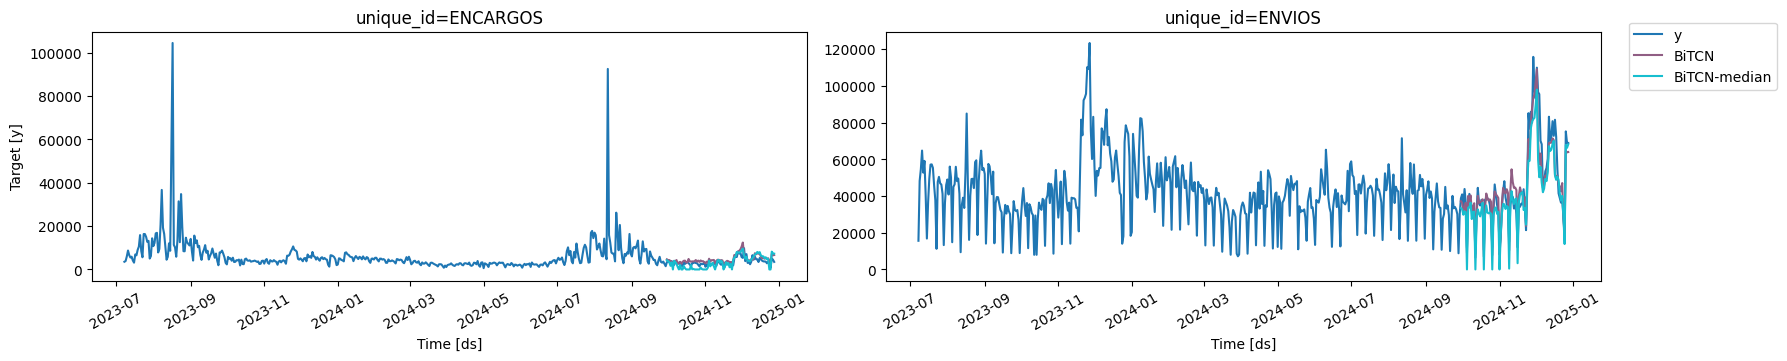

In [87]:
plot_series(train_data, Y_hat_df, max_insample_length=horizon*5)


In [53]:
# df_fore.to_csv(f'RESULTADOS_TOTD.csv', index=False)

In [107]:
df_fore

,LABEL,FECHA,Y,DT_REF,SESSION_TAG,FUTURE,KEY_DS,CO_TIPO_METODO_ENVIO,KEY,LABEL_N0,LABEL_N1,LABEL_N2,LABEL_N3,LABEL_N4,LABEL_N5,LABEL_N6,LABEL_N7,VARIANT,YHATFIN
0,ENCARGOS,2024-09-30,3351.0,2024-09-29,TEST,1,LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL,ENCARGOS,ENCARGOS,LibeCsT,ENCARGOS,ALL,ALL,ALL,ALL,ALL,ALL,BiTCN,2879.365967
1,ENCARGOS,2024-10-01,3739.0,2024-09-29,TEST,1,LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL,ENCARGOS,ENCARGOS,LibeCsT,ENCARGOS,ALL,ALL,ALL,ALL,ALL,ALL,BiTCN,3184.854004
2,ENCARGOS,2024-10-02,3393.0,2024-09-29,TEST,1,LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL,ENCARGOS,ENCARGOS,LibeCsT,ENCARGOS,ALL,ALL,ALL,ALL,ALL,ALL,BiTCN,1933.626953
3,ENCARGOS,2024-10-03,2737.0,2024-09-29,TEST,1,LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL,ENCARGOS,ENCARGOS,LibeCsT,ENCARGOS,ALL,ALL,ALL,ALL,ALL,ALL,BiTCN,2773.607910
4,ENCARGOS,2024-10-04,3836.0,2024-09-29,TEST,1,LibeCsT_ENCARGOS_ALL_ALL_ALL_ALL_ALL_ALL,ENCARGOS,ENCARGOS,LibeCsT,ENCARGOS,ALL,ALL,ALL,ALL,ALL,ALL,BiTCN,1589.871948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,ENVIOS,2024-12-24,28260.0,2024-09-29,TEST,1,LibeCsT_ENVIOS_ALL_ALL_ALL_ALL_ALL_ALL,ENVIOS,ENVIOS,LibeCsT,ENVIOS,ALL,ALL,ALL,ALL,ALL,ALL,BiTCN,24583.013672
176,ENVIOS,2024-12-25,20553.0,2024-09-29,TEST,1,LibeCsT_ENVIOS_ALL_ALL_ALL_ALL_ALL_ALL,ENVIOS,ENVIOS,LibeCsT,ENVIOS,ALL,ALL,ALL,ALL,ALL,ALL,BiTCN,19726.566406
177,ENVIOS,2024-12-26,75225.0,2024-09-29,TEST,1,LibeCsT_ENVIOS_ALL_ALL_ALL_ALL_ALL_ALL,ENVIOS,ENVIOS,LibeCsT,ENVIOS,ALL,ALL,ALL,ALL,ALL,ALL,BiTCN,57886.968750
178,ENVIOS,2024-12-27,68908.0,2024-09-29,TEST,1,LibeCsT_ENVIOS_ALL_ALL_ALL_ALL_ALL_ALL,ENVIOS,ENVIOS,LibeCsT,ENVIOS,ALL,ALL,ALL,ALL,ALL,ALL,BiTCN,53977.980469


In [33]:
from snowflake.snowpark.functions import col, to_date, to_char

# Crear el DataFrame de Snowpark a partir del DataFrame de pandas
snowpark_df = sess.create_dataframe(df_fore)
snowpark_df = snowpark_df.with_column("FECHA", to_date(col("FECHA")))
snowpark_df = snowpark_df.with_column("DT_REF", to_char(col("DT_REF"), 'YYYY-MM-DD'))



# Lista de columnas que espera la tabla destino
columnas_tabla = [
    "LEVEL", "KEY", "DT_REF", "SESSION_TAG", "ESTIMATOR", "VARIANT",
    "LABEL", "LABEL_N0", "LABEL_N1", "LABEL_N2", "LABEL_N3",
    "LABEL_N4", "LABEL_N5", "LABEL_N6", "LABEL_N7", "KV", "STEP",
    "FUTURE", "FECHA", "Y", "YHAT", "YHAT1", "YHAT2", "YHAT3", "YHAT4",
    "YHAT5", "YHAT6", "YHAT7", "YHAT8", "YHATFIN", "YHAT_L", "YHAT_U",
    "SLOT_0", "SLOT_1", "SLOT_2", "SLOT_3", "SLOT_4", "SLOT_5", "SLOT_6",
    "SLOT_7", "SLOT_8", "SLOT_9", "SLOT_10", "SLOT_11", "SLOT_12",
    "SLOT_13", "SLOT_14", "SLOT_15", "SLOT_16", "SLOT_17", "SLOT_18",
    "SLOT_19", "SLOT_20", "SLOT_21", "SLOT_22", "SLOT_23", "SLOT_24",
    "DSLOT_TREND_0", "DSLOT_TREND_1", "NFO", "SET"
]

# Lista de columnas que tiene tu DataFrame de Snowpark (18 columnas)
columnas_existentes = snowpark_df.columns

# Agregar las columnas faltantes con un valor por defecto (None)
for col in set(columnas_tabla) - set(columnas_existentes):
    snowpark_df = snowpark_df.with_column(col, lit(None))

# Reordenar las columnas para que coincidan con el orden de la tabla destino
snowpark_df = snowpark_df.select(columnas_tabla)

snowpark_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"LEVEL"  |"KEY"     |"DT_REF"    |"SESSION_TAG"             |"ESTIMATOR"  |"VARIANT"  |"LABEL"   |"LABEL_N0"  |"LABEL_N1"  |"LABEL_N2"  |"LABEL_N3"  |"LABEL_N4"  |"LABEL_N5"  |"LABEL_N6"  |"LABEL_N7"  |"KV"  |"STEP"  |"FUTURE"  |"FECHA"     |"Y"     |"YHAT"  |"YHAT1"  |"Y

In [34]:
snowpark_df.write.mode("append").save_as_table("CAA_UAT.STG_FCDP.TB_DEMAND_PLANNING_FORECAST_JAQB_TEMP_DEV")

In [ ]:

# snowpark_df.write.save_as_table(table_name='FORECAST_REDES_JAQB',mode='overwrite')
# snowpark_df.write.mode("overwrite").save_as_table("esquema.tabla_destino")
# print("DataFrame cargado exitosamente en Snowflake usando Snowpark.")

DataFrame cargado exitosamente en Snowflake usando Snowpark.
